In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

%matplotlib inline

### Reading ANIMELIST.CSV

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

### DATA PROCESSING

In [7]:
n_ratings = rating_df['user_id'].value_counts()

rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)]

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df['rating'])

In [10]:
max_rating = max(rating_df['rating'])

In [11]:
avg_rating = np.mean(rating_df['rating'])

In [12]:
avg_rating

np.float64(4.122732695114736)

In [13]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float32)

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [17]:
n_users = len(user2user_encoded)

In [18]:
n_users

4203

In [19]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [20]:
n_anime = len(anime2anime_encoded)

In [21]:
n_anime

17149

In [22]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [23]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [24]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [25]:
X = rating_df[['user', 'anime']].values
Y = rating_df['rating']

In [26]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [27]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    Y[:train_indices],
    Y[train_indices:]
)

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3245641, 1000, 3245641, 1000)

In [29]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [30]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [31]:
type(X_train_array), type(X_test_array[0])

(list, numpy.ndarray)

#### MODEL ARCHITECTURE

In [32]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name='user', shape=[1])

    user_embedding = Embedding(name='user_embedding', input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae', 'mse'])

    return model


In [33]:
model = RecommenderNet()

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [35]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr

In [36]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

In [37]:
my_callback = [model_checkpoint, lr_callback, early_stopping]

In [38]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callback
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - loss: 0.7963 - mae: 0.3813 - mse: 0.1960 - val_loss: 0.7229 - val_mae: 0.3679 - val_mse: 0.1696 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - loss: 0.7928 - mae: 0.3800 - mse: 0.1946 - val_loss: 0.7949 - val_mae: 0.3834 - val_mse: 0.1964 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - loss: 0.7870 - mae: 0.3779 - mse: 0.1923 - val_loss: 0.8034 - val_mae: 0.3849 - val_mse: 0.1991 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - loss: 0.7788 - mae: 0.3747 - mse: 0.1890 - val_loss: 0.7999 - val_mae: 0.3841 - val_mse: 0.1978 - learning_rate: 3.4000e-05


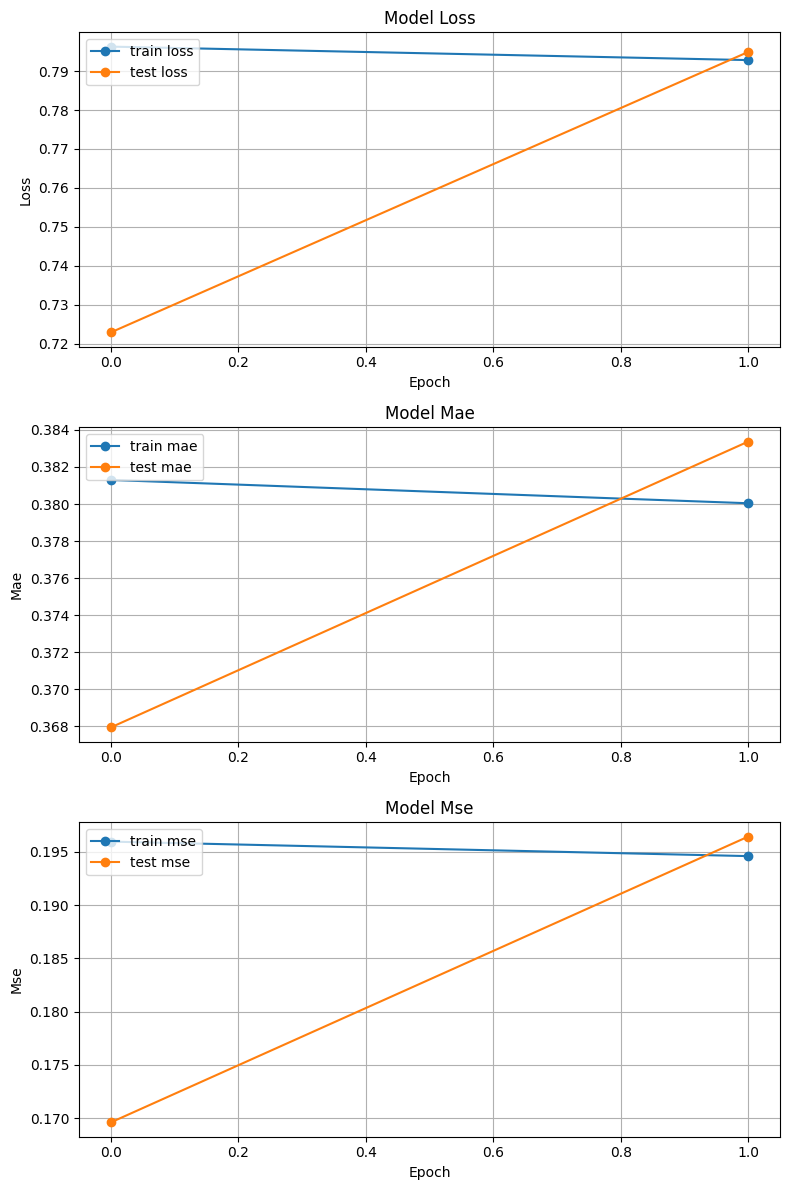

In [39]:
metrics = ['loss', 'mae', 'mse']

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker='o', label=f'train {metric}')
    ax.plot(history.history[f'val_{metric}'][0:-2], marker='o', label=f'test {metric}')
    ax.set_title(f'Model {metric.capitalize()}')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [40]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [41]:
anime_weights = extract_weights('anime_embedding', model)

In [42]:
user_weights = extract_weights('user_embedding', model)

### READING ANIME.CSV

In [43]:
df  = pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [44]:
df = df.replace("Unknown", np.nan)

In [45]:
def getAnimeName(anime_id):
    try:
        name = df[df['anime_id'] == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df['anime_id'] == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [46]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [47]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [48]:
getAnimeName(67)

'Basilisk'

In [49]:
df.sort_values(by="Score",
               ascending=False,
               inplace=True,
               kind="quicksort",
               na_position='last')

In [50]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [51]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [52]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [53]:
def getAnimeFrame(anime, id):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [54]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [55]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV

In [56]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [57]:
synopsis_df  = pd.read_csv(INPUT_DIR + "/anime_with_synopsis.csv", usecols=cols)

In [58]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [59]:
# def getSynopsis(anime_id, df):
#     if isinstance(anime_id, int):
#         return synopsis_df[synopsis_df.MAL_ID == anime_id].sypnopsis.values[0]
#     if isinstance(anime_id, str):
#         return synopsis_df[synopsis_df.Name == anime_id].sypnopsis.values[0]

def getSynopsis(anime_id, df):
    if isinstance(anime_id, int):
        result = synopsis_df[synopsis_df.MAL_ID == anime_id]
        if not result.empty:
            return result.sypnopsis.values[0]
        else:
            return "Synopsis not found"
    if isinstance(anime_id, str):
        result = synopsis_df[synopsis_df.Name == anime_id]
        if not result.empty:
            return result.sypnopsis.values[0]
        else:
            return "Synopsis not found"

In [60]:
getSynopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

### CONTENT/ITEM BASED RECOMMENDATION

In [61]:
pd.set_option("max_colwidth", None)

In [62]:
def find_similar_animes(name, anime_weights, anime2anime_encoded,
                         anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1 

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            synopsis = getSynopsis(decoded_id, synopsis_df)

            anime_frame = getAnimeFrame(decoded_id, df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]    
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id, 
                "name": anime_name, 
                "similarity": similarity, 
                "genre": genre, 
                "synopsis": synopsis
            })
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop("anime_id", axis=1)
        
    except Exception as e:
        print(f"Error Occurred: {e}")


In [63]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2
)

,name,similarity,genre,synopsis
1,Divine Gate,0.315204,"Action, Sci-Fi, Fantasy","The legend of the Divine Gate is a story told to young children that depicts the merging of the living world, the heavens, and the underworld. ""Adapters""—people born with unique elemental abilities gifted to them from the union of these worlds—formed the World Council, an organization which controls the chaos of the Gate by portraying its legend as nothing more than a myth. These Adapters train in a special academy owned by the World Council that allows the students to hone their skills. Aoto, a teenage boy with exceptional water powers and a tragic past, rejects the offer to join the academy numerous times—until he is successfully pressured by the energetic wind user Midori and stubborn fire user Akane. Together, with the World Council and their mysterious leader Arthur, they seek out the Gate in the hopes of uncovering the truth. But in order to reach their goals, they must unite and overcome their own despair while dealing with behind the scene mischief."
0,Ocha-ken: Chokotto Monogatari,0.309697,"Comedy, Kids","Ocha-ken is a children's program about tea-dogs and tea-cats, each representing a different blend. The episodes are very short and geared to teaching the audience various values. The lesson, or moral of the episode is displayed at the end. (Source: AniDB)"


### USER BASED RECOMMENDATION

In [73]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        if encoded_index is None:
            print(f"User {index} not found.")
            return pd.DataFrame()

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id, 
                    "similarity": similarity
                })

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != index]
        return similar_users
    except Exception as e:
        print(f"Error Occurred: {e}")
        

In [76]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,11703,0.344667
8,9747,0.318079
7,629,0.311848
6,1886,0.309574
5,14935,0.294247
4,12256,0.291970
3,8522,0.280027
2,12304,0.278839
1,10487,0.278039
0,13017,0.268497


In [77]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [78]:
from collections import defaultdict

In [79]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []

    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)

    return genres_list


In [80]:
x = getAnimeFrame(1, df)

In [81]:
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


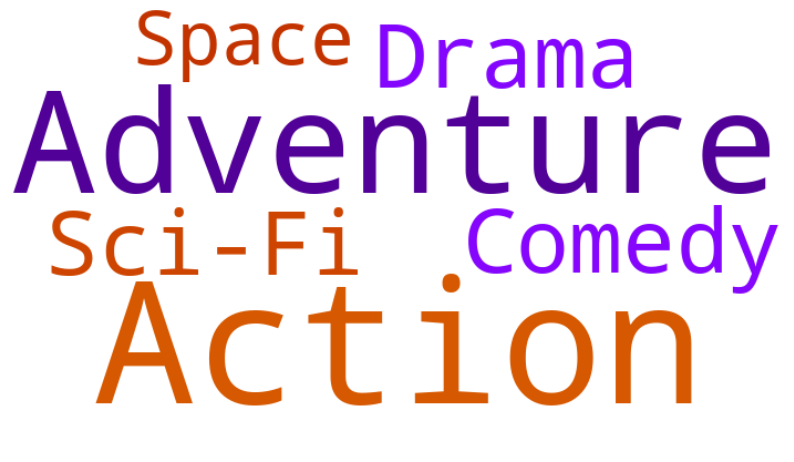

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [83]:
getFavGenre(x, plot=True)

In [84]:
def get_user_preferences(user_id, rating_df, verbose=0, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]   

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    ) 

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot=True)

    return anime_df_rows

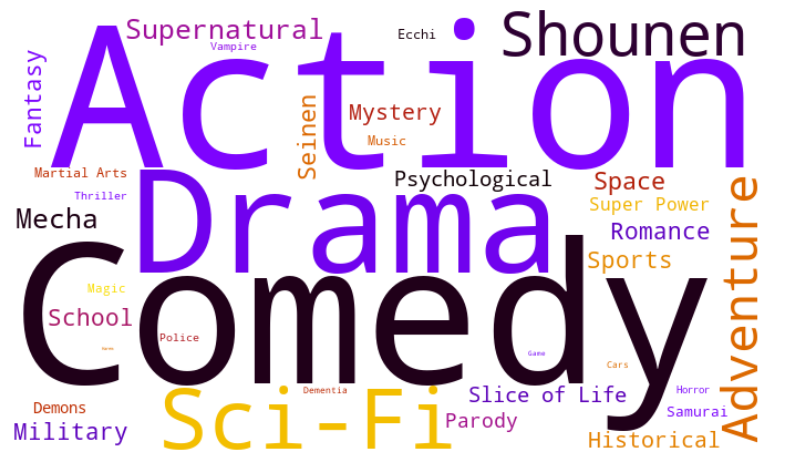

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [89]:
get_user_preferences(11880, rating_df)
get_user_preferences(11880, rating_df, df, plot=True)

In [87]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n": n_user_pref, 
                        "anime_names": anime_name, 
                        "Genres": genre, 
                        "Synopsis": synopsis
                    })

    return pd.DataFrame(recommended_animes).head(n)



In [88]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

In [93]:
user_pref = get_user_preferences(11880, rating_df, df, plot=False)

In [96]:
get_user_recommendations(similar_users,user_pref, df, synopsis_df, rating_df, n=2)

,n,anime_names,Genres,Synopsis
0,9,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari High School, is the sole heir to an intimidating yakuza family. Ten years ago, Raku made a promise to his childhood friend. Now, all he has to go on is a pendant with a lock, which can only be unlocked with the key which the girl took with her when they parted. Now, years later, Raku has grown into a typical teenager, and all he wants is to remain as uninvolved in his yakuza background as possible while spending his school days alongside his middle school crush Kosaki Onodera. However, when the American Bee Hive Gang invades his family's turf, Raku's idyllic romantic dreams are sent for a toss as he is dragged into a frustrating conflict: Raku is to pretend that he is in a romantic relationship with Chitoge Kirisaki, the beautiful daughter of the Bee Hive's chief, so as to reduce the friction between the two groups. Unfortunately, reality could not be farther from this whopping lie—Raku and Chitoge fall in hate at first sight, as the girl is convinced he is a pathetic pushover, and in Raku's eyes, Chitoge is about as attractive as a savage gorilla. Nisekoi follows the daily antics of this mismatched couple who have been forced to get along for the sake of maintaining the city's peace. With many more girls popping up his life, all involved with Raku's past somehow, his search for the girl who holds his heart and his promise leads him in more unexpected directions than he expects."
1,8,Noragami Aragoto,"Action, Adventure, Comedy, Supernatural, Shounen","Yato and Yukine have finally mended their relationship as god and Regalia, and everyone has returned to their daily life. Yato remains a minor and unknown deity who continues taking odd jobs for five yen apiece in the hopes of one day having millions of worshippers and his own grand shrine. Hiyori Iki has yet to have her loose soul fixed by Yato, but she enjoys life and prepares to attend high school nonetheless. Taking place immediately after the first season, Noragami Aragoto delves into the complicated past between Yato and the god of war Bishamon. The female god holds a mysterious grudge against Yato, which often results in violent clashes between them. It doesn't help that Bishamon's most trusted and beloved Regalia, Kazuma, appears to be indebted to Yato. When lives are on the line, unraveling these mysteries and others may be the only way to correct past mistakes."


### HYBRID RECOMMENDER SYSTEM

In [ ]:
def hybrid_recommendation(user_id, user_weight=0.4, content_weight=0.6):
    
    #### User Recommendation
    
    similar_users = find_similar_users(int(user_id), user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(int(user_id), rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_users,user_pref, df, synopsis_df, rating_df)

    user_recommended_animes_list = user_recommended_animes["anime_names"].tolist()
    print(f"User {user_id} recommended animes: {user_recommended_animes_list}")
    
    ###### Content Recommendation

    content_recommended_animes = []

    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df,n=2)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar animes found for {anime}.")  

    combined_socres = {}

    for anime in user_recommended_animes_list:
        combined_socres[anime] = combined_socres.get(anime, 0) + user_weight

    for anime in content_recommended_animes:
        combined_socres[anime] = combined_socres.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_socres.items(), key=lambda x: x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]



In [113]:
hybrid_recommendation(13994)

User 13994 recommended animes: ['GATE', 'Aldnoah.Zero', 'Beyond the Boundary', 'Hotarubi no Mori e', 'Nisekoi:False Love', 'Sword Art Online', 'That Time I Got Reincarnated as a Slime', 'Tokyo Ghoul', 'My Hero Academia', 'Food Wars! Shokugeki no Soma']


['Inyouchuu The Animation',
 'Shin Obake no Q-tarou',
 'Bokura Machi Bouzu!',
 'Alice in Cyberland',
 'Doko kara Kita no',
 'Panda! Go Panda!',
 'Time Stranger',
 'Alice in Dreamland',
 'Dream Star Button Nose',
 'Watashitachi, Luck Logic-bu! 2']